In [1]:
import numpy as np
import pandas as pd
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
import spacy
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [2]:
df = pd.read_csv("specific_irs_forms.csv")

In [3]:
data = df["Instruction in HTML"]

In [4]:
# Join the different series elements together.
text = ','.join(list(data.values))

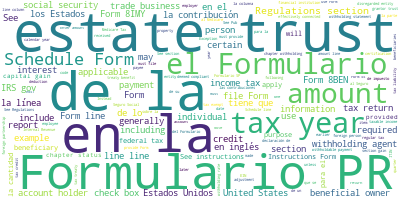

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(text)
# Visualize the word cloud
wordcloud.to_image()

# Topic Modeling 

### Using the data that was webscraped that was publicly available on IRS's public website. With the data, the goal is to now divide the data into several different categories, and find topics (consisting of groups of words) for them. Knowing the actual categories helps us evaluate if the topics make sense.

### We will try this with two different matrix factorizations: Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF)

In [6]:
train, test = train_test_split(df, test_size = 0.2)

In [7]:
#will extract all word counts 
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(train["Instruction in HTML"]).todense() # (documents, vocab)
vectors.shape

(18, 7941)

In [8]:
vocab = np.array(vectorizer.get_feature_names())


In [9]:
vocab.shape

(7941,)

In [10]:
vocab[1:6]

array(['000', '0005', '001', '002', '003'], dtype='<U26')

In [11]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)


CPU times: user 70.6 ms, sys: 19 ms, total: 89.6 ms
Wall time: 144 ms


In [12]:
print(U.shape, s.shape, Vh.shape)


(18, 18) (18,) (18, 7941)


In [13]:
num_top_words=15
#after vecotrizing, finding word frequency, and using SVD, we can present the data in topics 
#this is just an exploratory model to look at the data in a better organized way/see immediate results. 
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [14]:
show_topics(Vh[:10])


['trimeste individuales reportar horas reporta marcó volverá ayude seleccionado 943a sencillo estimado estimados sexto dependiendo',
 'trust income estate form 1041 foreign section beneficiary schedule withholding deduction trusts entity grantor qualified',
 'la el en que para al los por formulario 941 las si del pr su',
 'trust estate tax 1041 schedule year beneficiary income deduction return trusts property qualified decedent loss',
 'trust estate income foreign 1041 withholding 17 chapter beneficiary entity ffi trusts la el deduction',
 'income return tax information file trust 941 taxes trusts beneficiary quarter paid credit irs wages',
 'gain column trust _____ sale estate 941 stock 000 enter report form withholding reported capital',
 'withholding quarter schedule pool ss chapter gain provide taxes irs statement deposit payroll qi reporting',
 'form gain business 8ben ss irs account information quarter payroll deposit return section forms substitute',
 'form withholding amt state

# Non-negative Matrix Factorization (NMF) 

In [15]:
m,n=vectors.shape
d=4  # num topics

In [16]:
#actual nmf model
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [17]:
#only 4 topics selected here to initially compare results with svd seen above. 
show_topics(H1)


['trust form tax income estate line section schedule 1041 year return beneficiary information deduction enter',
 '17 18 16 19 20 15 326 421 employee 14 21 coverage tax credit line',
 'la el en que para al los por formulario 941 las si del pr su',
 'form withholding foreign chapter ffi entity payment section line provide status account regulations required person']

## Topic Frequency-Inverse Document Frequency (TF-IDF) is a way to normalize term by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

In [18]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(train["Instruction in HTML"])

In [19]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [20]:
#these topics may inform the configuration of our chatbot, i.e. what intents and conversation flows can be made from these topics? 
show_topics(H1)


['form foreign withholding ffi chapter 8ben entity income agent treaty section person payment iga account',
 '941 form tax quarter line column wages tips schedule file medicare employees security social credit',
 'el la en que para formulario del al los pr las anexo por si su',
 'form trust line estate tax income 1041 gain amt schedule deduction section loss property beneficiary']

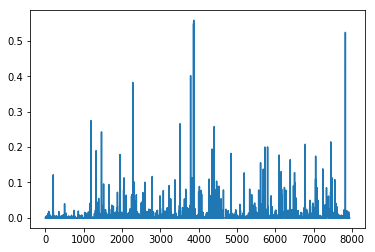

In [21]:
plt.plot(clf.components_[0])


In [22]:
clf.reconstruction_err_


2.4130822418550486

In [23]:
# NLTK Stop words
from nltk.corpus import stopwords


In [24]:
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Latent Dirichlet Allocation (LDA)

## LDA is another unsupervised model that treats each document as a mixture of a small number of topics. Each word's presence is then attributable to one of the document's topics.

In [25]:
#remove punctuation and extra characters to extract only words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['instructions', 'for', 'form', 'employer', 'quarterly', 'federal', 'tax', 'return', 'section', 'references', 'are', 'to', 'the', 'internal', 'revenue', 'code', 'unless', 'otherwise', 'noted', 'revised', 'instructions', 'for', 'form', 'introductory', 'material', 'future', 'developments', 'for', 'the', 'latest', 'information', 'about', 'developments', 'related', 'to', 'form', 'and', 'its', 'instructions', 'such', 'as', 'legislation', 'enacted', 'after', 'they', 'were', 'published', 'go', 'to', 'irs', 'gov', 'form', 'what', 'new', 'withholding', 'tables', 'the', 'federal', 'income', 'tax', 'withholding', 'tables', 'are', 'now', 'included', 'in', 'pub', 'federal', 'income', 'tax', 'withholding', 'methods', 'social', 'security', 'and', 'medicare', 'tax', 'for', 'the', 'social', 'security', 'tax', 'rate', 'is', 'each', 'for', 'the', 'employee', 'and', 'employer', 'unchanged', 'from', 'the', 'social', 'security', 'wage', 'base', 'limit', 'is', 'the', 'medicare', 'tax', 'rate', 'is', 'each',

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['instructions', 'for', 'form', 'employer', 'quarterly', 'federal', 'tax', 'return', 'section', 'references', 'are', 'to', 'the', 'internal_revenue', 'code', 'unless_otherwise_noted', 'revised', 'instructions', 'for', 'form', 'introductory_material_future_developments', 'for', 'the', 'latest', 'information', 'about_developments_related', 'to', 'form', 'and', 'its', 'instructions', 'such', 'as', 'legislation_enacted_after', 'they_were_published', 'go', 'to', 'irs', 'gov', 'form', 'what_new', 'withholding', 'tables', 'the', 'federal', 'income', 'tax', 'withholding', 'tables', 'are', 'now', 'included', 'in', 'pub', 'federal', 'income', 'tax', 'withholding', 'methods', 'social_security', 'and', 'medicare', 'tax', 'for', 'the', 'social_security', 'tax', 'rate', 'is', 'each', 'for', 'the', 'employee', 'and', 'employer', 'unchanged', 'from', 'the', 'social_security', 'wage_base', 'limit', 'is', 'the', 'medicare', 'tax', 'rate', 'is', 'each', 'for', 'the', 'employee', 'and', 'employer', 'uncha

In [27]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

nlp = spacy.load("en", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['instruction', 'form', 'employer', 'quarterly', 'federal', 'tax', 'return', 'section', 'reference', 'code', 'otherwise_note', 'revise', 'instruction', 'form', 'future_development', 'late', 'information', 'developments_related', 'form', 'instruction', 'legislation_enacte', 'form', 'new', 'withholding', 'table', 'federal', 'income', 'tax', 'withholding', 'table', 'include', 'federal', 'income', 'tax', 'withholding', 'social_security', 'tax', 'rate', 'employee', 'employer', 'unchanged', 'social_security', 'limit', 'tax', 'rate', 'employee', 'employer', 'unchanged', 'limit', 'taxis', 'apply', 'wage', 'household', 'worker', 'pay', 'cash', 'wage', 'taxis', 'apply', 'election', 'worker', 'pay', 'cash', 'equivalent', 'form', 'compensation', 'reminder', 'qualify', 'small', 'business', 'payroll', 'tax', 'credit', 'increasing_research', 'activity', 'tax', 'qualified', 'small', 'business', 'may', 'elect', 'claim', 'credit', 'activity', 'payroll', 'tax', 'credit', 'employer', 'share', 'social_sec

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 1), (3, 2), (4, 1), (5, 2), (6, 6), (7, 1), (8, 2), (9, 4), (10, 2), (11, 2), (12, 1), (13, 3), (14, 2), (15, 1), (16, 12), (17, 1), (18, 3), (19, 1), (20, 12), (21, 20), (22, 6), (23, 31), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 12), (30, 5), (31, 1), (32, 9), (33, 1), (34, 1), (35, 2), (36, 1), (37, 4), (38, 19), (39, 1), (40, 1), (41, 2), (42, 53), (43, 4), (44, 1), (45, 3), (46, 4), (47, 2), (48, 3), (49, 1), (50, 1), (51, 1), (52, 34), (53, 2), (54, 3), (55, 2), (56, 3), (57, 3), (58, 1), (59, 3), (60, 2), (61, 9), (62, 2), (63, 1), (64, 6), (65, 1), (66, 1), (67, 3), (68, 8), (69, 2), (70, 1), (71, 13), (72, 1), (73, 5), (74, 2), (75, 1), (76, 1), (77, 6), (78, 4), (79, 4), (80, 7), (81, 2), (82, 1), (83, 4), (84, 1), (85, 5), (86, 29), (87, 1), (88, 53), (89, 11), (90, 8), (91, 3), (92, 1), (93, 3), (94, 1), (95, 1), (96, 5), (97, 1), (98, 5), (99, 1), (100, 6), (101, 4), (102, 1), (103, 2), (104, 13), (105, 10), (106, 1), (107, 27), (108, 1), (10

In [30]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('abate', 1),
  ('abatement', 3),
  ('able', 1),
  ('accept', 2),
  ('acceptable', 1),
  ('accord', 2),
  ('account', 6),
  ('accrue', 1),
  ('accumulate', 2),
  ('accuracy', 4),
  ('accurate', 2),
  ('accurately', 2),
  ('acquisition', 1),
  ('act', 3),
  ('action', 2),
  ('active', 1),
  ('activity', 12),
  ('actually', 1),
  ('add', 3),
  ('addition', 1),
  ('additional', 12),
  ('address', 20),
  ('adjust', 6),
  ('adjustment', 31),
  ('administration', 1),
  ('advice', 1),
  ('advise', 2),
  ('affect', 1),
  ('agency', 1),
  ('agent', 12),
  ('aggregate', 5),
  ('agree', 1),
  ('agreement', 9),
  ('agricultural', 1),
  ('ahead', 1),
  ('allocate', 2),
  ('allocation', 1),
  ('allow', 4),
  ('also', 19),
  ('alternative', 1),
  ('alternatively', 1),
  ('always', 2),
  ('amount', 53),
  ('annual', 4),
  ('annually', 1),
  ('answer', 3),
  ('anticipation', 4),
  ('appear', 2),
  ('applicable', 3),
  ('application', 1),
  ('applie', 1),
  ('applied', 1),
  ('apply', 34),
  ('appropr

## It will be important to understand the optimal number of topics, given that this number will determine how many intents we will start with for our chatbot framework. To do this, we compute the coherence scores of multiple LDA models that use a range of different topic values. The model with the high coherence score will indicate the optimal number of topics.

In [31]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


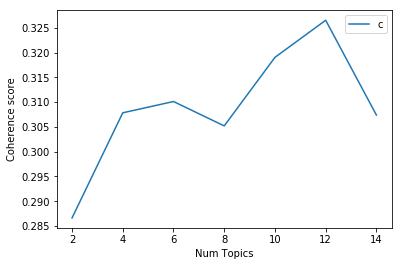

In [33]:
# Show graph measuring coherence according to number of topics
limit=16; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2866
Num Topics = 4  has Coherence Value of 0.3079
Num Topics = 6  has Coherence Value of 0.3101
Num Topics = 8  has Coherence Value of 0.3052
Num Topics = 10  has Coherence Value of 0.3191
Num Topics = 12  has Coherence Value of 0.3265
Num Topics = 14  has Coherence Value of 0.3074


In [53]:
lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=id2word)
topics = lda_model.show_topics(formatted=False)


In [54]:
#find out results of LDA model. Appears there's not much difference between topics.
lda_model.print_topics()

[(0,
  '0.040*"form" + 0.032*"line" + 0.031*"tax" + 0.011*"trust" + 0.011*"section" + 0.011*"income" + 0.010*"must" + 0.010*"foreign" + 0.010*"amount" + 0.010*"return"'),
 (1,
  '0.028*"form" + 0.021*"line" + 0.017*"tax" + 0.013*"section" + 0.013*"income" + 0.012*"amount" + 0.011*"foreign" + 0.010*"must" + 0.009*"use" + 0.009*"withholding"'),
 (2,
  '0.025*"form" + 0.023*"line" + 0.019*"section" + 0.016*"foreign" + 0.016*"payment" + 0.015*"tax" + 0.014*"withholding" + 0.012*"income" + 0.011*"require" + 0.011*"provide"'),
 (3,
  '0.022*"tax" + 0.021*"form" + 0.019*"line" + 0.015*"file" + 0.012*"enter" + 0.012*"amount" + 0.012*"section" + 0.011*"pay" + 0.011*"income" + 0.010*"must"'),
 (4,
  '0.040*"form" + 0.029*"tax" + 0.019*"line" + 0.018*"trust" + 0.016*"income" + 0.014*"file" + 0.014*"schedule" + 0.012*"amount" + 0.012*"report" + 0.011*"section"'),
 (5,
  '0.038*"form" + 0.028*"line" + 0.023*"tax" + 0.020*"income" + 0.020*"trust" + 0.018*"amount" + 0.014*"must" + 0.011*"report" + 0.

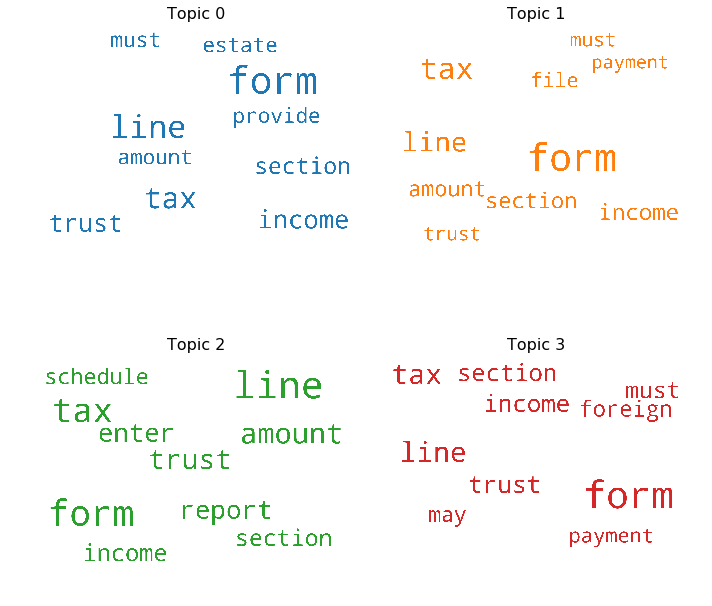

In [36]:
# 1. Wordcloud of Top N words in each topic


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=id2word)

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/owner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.010983  0.004116       1        1  28.373173
4     -0.001448 -0.007790       2        1  22.992201
1      0.002802  0.008353       3        1  22.230896
2      0.014299 -0.000597       4        1  16.546518
0     -0.004670 -0.004081       5        1   9.857207, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
355   Default  2222.000000         line  2222.000000  30.0000  30.0000
278   Default  3480.000000         form  3480.000000  29.0000  29.0000
228   Default   836.000000        enter   836.000000  28.0000  28.0000
606   Default  2253.000000          tax  2253.000000  27.0000  27.0000
316   Default  1556.000000       income  1556.000000  26.0000  26.0000
638   Default  1351.000000        trust  1351.000000  25.0000  25.0000
238   Default   645.000000       estate   645.000000  24.0000  24.0000
42    Default  1209.000000       amount  1209.000000  23.0000  23.0000
520   Default   828.000000       report   828.000000  22.0000  22.0000
118   Default   452.000000       column   452.000000  21.0000  21.0000
486   Default   801.000000      provide   801.000000  20.0000  20.0000
1617  Default   440.000000         gain   440.000000  19.0000  19.0000
111   Default   448.000000        claim   448.000000  18.0000  18.0000
164   Default   462.000000    deduction   462.000000  17.0000  17.0000
1388  Default   556.000000      chapter   556.000000  16.0000  16.0000
122   Default   433.000000     complete   433.000000  15.0000  15.0000
383   Default  1018.000000         must  1018.000000  14.0000  14.0000
550   Default  1294.000000      section  1294.000000  13.0000  13.0000
1000  Default   411.000000     property   411.000000  12.0000  12.0000
551   Default   800.000000          see   800.000000  11.0000  11.0000
653   Default   766.000000          use   766.000000  10.0000  10.0000
314   Default   858.000000      include   858.000000   9.0000   9.0000
88    Default   589.000000     business   589.000000   8.0000   8.0000
1603  Default   881.000000      foreign   881.000000   7.0000   7.0000
332   Default   501.000000     interest   501.000000   6.0000   6.0000
494   Default   275.000000      quarter   275.000000   5.0000   5.0000
546   Default   896.000000     schedule   896.000000   4.0000   4.0000
1739  Default   378.000000         loss   378.000000   3.0000   3.0000
152   Default   593.000000       credit   593.000000   2.0000   2.0000
525   Default   614.000000      require   614.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
228    Topic5    95.626434        enter   836.006104   0.1488  -4.5860
278    Topic5   343.681396         form  3480.387451   0.0018  -3.3068
88     Topic5    69.481392     business   589.172180   0.1793  -4.9054
638    Topic5   139.498001        trust  1351.223145   0.0463  -4.2084
6      Topic5    42.166924      account   347.579865   0.2076  -5.4049
525    Topic5    69.463333      require   614.911926   0.1363  -4.9057
1739   Topic5    45.286297         loss   378.792206   0.1930  -5.3335
316    Topic5   149.597061       income  1556.344727  -0.0252  -4.1385
434    Topic5    31.830418  partnership   253.189484   0.2433  -5.6861
606    Topic5   203.071274          tax  2253.427490  -0.0897  -3.8329
383    Topic5   102.110916         must  1018.270447   0.0172  -4.5204
551    Topic5    82.902771          see   800.927673   0.0489  -4.7288
231    Topic5    69.071213       entity   643.233582   0.0856  -4.9114
550    Topic5   121.284569      section  1294.569702  -0.0508  -4.3484
314    Topic5    81.963676      include   858.371460  -0.0318  -4.7402
491    Topic5    53.183556      purpose   493.209167   0.0898  -5.1727
332    Topic5    53.575340     interest   501.469147   0.0805  -5.1654
535    Topic5    64.416397   

In [38]:
#References for this notebook can be found here: https://github.com/fastai/numerical-linear-algebra 
#and here https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/